In [19]:
# 종합 실습: 피마 인디언 당뇨병 예측
# 당뇨병 발병 여부(outcome) 예측하는 모델
# 과거Data --> 모델링(학습)

In [20]:
# 데이터해석법
# 1.Data 가 불균형한지 , 불균형하면 AUC부터 봐야함

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix,precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler




In [22]:
# 데이터 로딩, 탐색적 분석
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [23]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [25]:
# 레이블 분포 확인 : 불균형하다.
diabetes_df['Outcome'].value_counts()

# 지도학습은 답이 결정한다 , # 학습은 답에 의해서

Outcome
0    500
1    268
Name: count, dtype: int64

In [26]:
# 통합 평가 함수
def get_clf_eval(y_test,pred,pred_proba=None): # 함수 하나가지고 두개 기능한다
                                               # None 안주면 함수 호출할때 문제생김
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1=f1_score(y_test,pred)
    
    # AUC score
    roc_auc = roc_auc_score(y_test,pred_proba)
    print('오차 행렬')
    print(confusion)
    print(f'정확도 : {accuracy:.4f} , 정밀도:{precision:.4f},재현율:{recall:.4f},F1:{f1:.4f},AUC:{roc_auc:.4f}')

In [36]:
# ROC curve  시각화
def precision_recall_curve_plot(y_test,pred_proba_c1) :
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    # X축을 threshold, Y축은 정밀도, 재현율 값으로 각각 plot(선그래프)
    plt.figure(figsize=(8,6))    
    threshold_boundary = thresholds.shape[0]
    # print(f'임계값 경계: {threshold_boundary}')

# <로깅>: 설정하나로 찍힐수 있게 또는 안찍힐수 있게 할 수 있다.
#      - 원하는 레벨에 맞춰서 찍히게 또는 안찍히게 할 수 있다.
#      - 함수만들때 특히 필요함

    plt.plot(thresholds,precisions[:threshold_boundary],linestyle = '--',label='precision')
    plt.plot(thresholds, recalls[:threshold_boundary],label='recall')

    # start,end 값 리턴한다
    start,end = plt.xlim() # S|||||||||||||||||||||||||||e
    plt.xticks(np.round(np.arange(start,end,0.1),2)) # 이래야 곡선처럼 보인다 , 어쨌든 선 그래프이다.



In [28]:
# 데이터/답 분리
# diabetes_df.head()
X = diabetes_df.iloc[:,:-1] # 마지막열을 제외한 모든 열 선택
# loc 위주로 쓰는게 좋다.
y = diabetes_df.iloc[:,-1]

# 학습/ 테스트 분리 : 계층적으로 분리해야함 즉, 파라미터 1개 더 줘야함
# 계층적 : 한쪽으로 쏠려있는데 이터 균형을 맞추기 위해서
# 데이터가 불균형일대 생각할게 많음
X_train, X_test,y_train,y_test = train_test_split(
    X,y,test_size = 0.2, random_state = 156,stratify = y # 뷸균형 레이블일때 계층적 추출   
) 
# 레이블 빠지면 데이터 안좋아질수 있음
# <주의>결과표에서 5개 0이다 = '측정이 안된다'의 의미
# 원래는 Null 이었는데 0으로 채웠다.

In [29]:
print(X_train.shape, X_test.shape)

(614, 8) (154, 8)


In [30]:
print(y_train.value_counts(),y_test.value_counts())

Outcome
0    400
1    214
Name: count, dtype: int64 Outcome
0    100
1     54
Name: count, dtype: int64


In [31]:
# 모델 생성, 학습, 평가
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train,y_train) # 학습 종료됨 ==>모델 나옴

# 평가 : 테스트 데이터에 대한 예측값, 예측확률, 원래답(y_test)
pred = lr_clf.predict(X_test)
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1] #class 1

get_clf_eval(y_test,pred,pred_proba_c1)
# 결과에서


오차 행렬
[[87 13]
 [22 32]]
정확도 : 0.7727 , 정밀도:0.7111,재현율:0.5926,F1:0.6465,AUC:0.8083


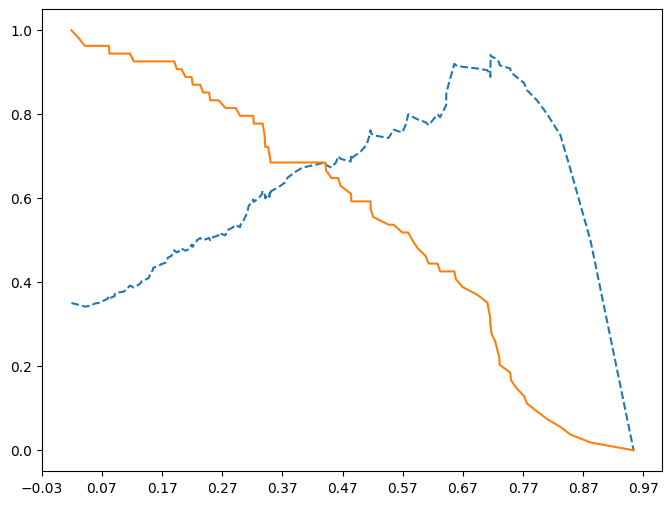

In [37]:
precision_recall_curve_plot(y_test, pred_proba_c1)

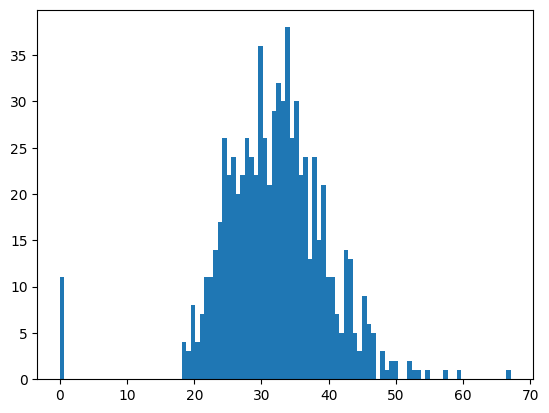

In [ ]:
# 피처들의 데이터 분포
plt.hist(diabetes_df['BMI'],bins=100)
plt.show()


In [ ]:
# 5개 컬럼(피처)의 0값을 평균으로 대체
# 각 피처 평균값 구한다.
Zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# 피처별 데이터 값이 0인 데이터의 건수와 퍼센트 계산
# 평균 = 합 / 개수

# 전체 데이터 건수
total_count = diabetes_df['Glucose'].count()
print(total_count)

# print(total_count)
for feature in Zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print(f'{feature}의 0건수는 {zero_count},퍼센트는 {zero_count/total_count*100:.2f}')
    # 0값만 추출

768
Glucose의 0건수는 5,퍼센트는 0.65
BloodPressure의 0건수는 35,퍼센트는 4.56
SkinThickness의 0건수는 227,퍼센트는 29.56
Insulin의 0건수는 374,퍼센트는 48.70
BMI의 0건수는 11,퍼센트는 1.43


In [ ]:
# 0값을 평균으로 대체
mean_Zero_features = diabetes_df[Zero_features].mean()
# 0아니놈들의 갯수를 빼서 평균내줘야함
diabetes_df[Zero_features] = diabetes_df[Zero_features].replace(0,mean_Zero_features)


In [ ]:
# 5개 컬럼(피처)의 0값을 평균으로 대체
# 각 피처 평균값 구한다.
Zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# 피처별 데이터 값이 0인 데이터의 건수와 퍼센트 계산
# 평균 = 합 / 개수

# 전체 데이터 건수
total_count = diabetes_df['Glucose'].count()
print(total_count)

# print(total_count)
for feature in Zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print(f'{feature}의 0건수는 {zero_count},퍼센트는 {zero_count/total_count*100:.2f}')
    # 0값만 추출

768
Glucose의 0건수는 0,퍼센트는 0.00
BloodPressure의 0건수는 0,퍼센트는 0.00
SkinThickness의 0건수는 0,퍼센트는 0.00
Insulin의 0건수는 0,퍼센트는 0.00
BMI의 0건수는 0,퍼센트는 0.00


In [ ]:
# 1.데이터/레이블 분리
X = diabetes_df.iloc[:,:-1] # 전체 데이터
y = diabetes_df.iloc[:,-1]

# 2.표준화 진행
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # 전체 데이터 fit(),transform()

# 3.학습/테스트 테이터 분리 -> 분리후 표준화 진행
# 학습데이터 대해 fit() -> 학습데이터 transform(),테스트데이터 transform()
X_train, X_test,y_train,y_test = train_test_split(
   X_scaled, y, test_size = 0.2,
   random_state = 156, stratify=y        
)

#  로지스틱 회귀로 학습,예측,평가 진행
lr_clf  = LogisticRegression(solver='liblinear')
# 학습
lr_clf.fit(X_train, y_train)

# 예측
pred = lr_clf.predict(X_test)
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba_c1) 

# 오차 행렬
# 재현율이 쪼금 올라감
# 오차 행렬
# [[90 10]
#  [21 33]]
# 정확도 : 0.7987 , 정밀도:0.7674,재현율:0.6111,F1:0.6804,AUC:0.8433
# 재현율: 0.6111 -> 100명중에 40명은 못잡는다.



오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987 , 정밀도:0.7674,재현율:0.6111,F1:0.6804,AUC:0.8433


In [ ]:
# semi 프로젝트는 불균형한 데이터르 가져감
# 임계값 처리 통해서 재현율 높이는 방식
from sklearn.preprocessing import Binarizer
def get_eval_by_threshold(y_test,pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        bina = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = bina.transform(pred_proba_c1)
        print(f'임계값 : {custom_threshold}')
        get_clf_eval(y_test,custom_predict,pred_proba_c1)
# 목표:재현율 높은 놈 찾겠따.

In [38]:

thresholds = [0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.51]
pred_proba = lr_clf.predict_proba(X_test) #예측 확률 

get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임계값 : 0.3
오차 행렬
[[63 37]
 [11 43]]
정확도 : 0.6883 , 정밀도:0.5375,재현율:0.7963,F1:0.6418,AUC:0.8083
임계값 : 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도 : 0.7403 , 정밀도:0.6000,재현율:0.7778,F1:0.6774,AUC:0.8083
임계값 : 0.36
오차 행렬
[[78 22]
 [17 37]]
정확도 : 0.7468 , 정밀도:0.6271,재현율:0.6852,F1:0.6549,AUC:0.8083
임계값 : 0.39
오차 행렬
[[82 18]
 [17 37]]
정확도 : 0.7727 , 정밀도:0.6727,재현율:0.6852,F1:0.6789,AUC:0.8083
임계값 : 0.42
오차 행렬
[[83 17]
 [17 37]]
정확도 : 0.7792 , 정밀도:0.6852,재현율:0.6852,F1:0.6852,AUC:0.8083
임계값 : 0.45
오차 행렬
[[83 17]
 [19 35]]
정확도 : 0.7662 , 정밀도:0.6731,재현율:0.6481,F1:0.6604,AUC:0.8083
임계값 : 0.48
오차 행렬
[[85 15]
 [21 33]]
정확도 : 0.7662 , 정밀도:0.6875,재현율:0.6111,F1:0.6471,AUC:0.8083
임계값 : 0.51
오차 행렬
[[88 12]
 [22 32]]
정확도 : 0.7792 , 정밀도:0.7273,재현율:0.5926,F1:0.6531,AUC:0.8083


In [39]:
# 이거하는 이유: 좋은 모델 뽑아낼려고

In [ ]:
# 임계값 0.33으로 설정해서 처리
bina = Binarizer(threshold=0.33)

pred_th_033 = bina.fit_transform(pred_proba[:,1].reshape(-1,1))
get_clf_eval(y_test,pred_th_033,pred_proba[:,1])

#그나마 재현율이 올라가 있는 모델이라고 할수 있다.

오차 행렬
[[72 28]
 [12 42]]
정확도 : 0.7403 , 정밀도:0.6000,재현율:0.7778,F1:0.6774,AUC:0.8083
